In [1]:
import os
import sys

import re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from skbio.diversity import beta_diversity
from skbio.stats.distance import mantel
from skbio.stats.ordination import pcoa
import scipy
from skbio.stats.distance import anosim

import pandas as pd
import seaborn as sns
import json
from natsort import natsorted


# Read the data

In [2]:
otu = pd.read_csv("/home/edwa0468/OneDrive/Projects/IBD/16S Sequences/20230831/ps0.UC.CD/ps0.UC.CD_otu.tsv", sep="\t")
sample = pd.read_csv("/home/edwa0468/OneDrive/Projects/IBD/16S Sequences/20230831/ps0.UC.CD/ps0.UC.CD_sample.tsv", sep="\t")
tax = pd.read_csv("/home/edwa0468/OneDrive/Projects/IBD/16S Sequences/20230831/ps0.UC.CD/ps0.UC.CD_tax.tsv", sep="\t")

In [3]:
otu

,GTAGGTCACAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGCGCAGGCGGGAAGACAAGTTGGAAGTGAAATCTATGGGCTCAACCCATAAACTGCTTTCAAAACTGTTTTTCTTGAGTAGTGCAGAGGTAGGCGGAATTCCCGGTGTAGCGGTGGAATGCGTAGATATCGGGAGGAACACCAGTGGCGAAGGCGGCCTACTGGGCACCAACTGACGCTGAGGCTCGAAAGTGTGGGTAGCAAAC,GGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGATGGATGTTTAAGTCAGTTGTGAAAGTTTGCGGCTCAACCGTAAAATTGCAGTTGATACTGGATATCTTGAGTGCAGTTGAGGCAGGCGGAATTCGTGGTGTAGCGGTGAAATGCTTAGATATCACGAAGAACTCCGATTGCGAAGGCAGCCTGCTAAGCTGCAACTGACATTGAGGCTCGAAAGTGTGGGTATCAAAC,GTAGGTCACAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGCGCAGGCGGGAAGACAAGTTGGAAGTGAAATCCATGGGCTCAACCCATGAACTGCTTTCAAAACTGTTTTTCTTGAGTAGTGCAGAGGTAGGCGGAATTCCCGGTGTAGCGGTGGAATGCGTAGATATCGGGAGGAACACCAGTGGCGAAGGCGGCCTACTGGGCACCAACTGACGCTGAGGCTCGAAAGTGTGGGTAGCAAAC,GTAGGGTGCAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGCGCAGGCGGGAAGACAAGTTGGAAGTGAAAACCATGGGCTCAACCCATGAATTGCTTTCAAAACTGTTTTTCTTGAGTAGTGCAGAGGTAGATGGAATTCCCGGTGTAGCGGTGGAATGCGTAGATATCGGGAGGAACACCAGTGGCGAAGGCGGTCTACTGGGCACCAACTGACGCTGAGGCTCGAAAGCATGGGTAGCAAAC,GTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGACGGTGTGGCAAGTCTGATGTGAAAGGCATGGGCTCAACCTGTGGACTGCATTGGAAACTGTCATACTTGAGTGCCGGAGGGGTAAGCGGAATTCCTAGTGTAGCGGTGAAATGCGTAGATATTAGGAGGAACACCAGTGGCGAAGGCGGCTTACTGGACGGTAACTGACGTTGAGGCTCGAAAGCGTGGGGAGCAAAC,GGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCACGCAGGCGGTTTGTTAAGTCAGATGTGAAATCCCCGGGCTCAACCTGGGAACTGCATCTGATACTGGCAAGCTTGAGTCTCGTAGAGGGGGGTAGAATTCCAGGTGTAGCGGTGAAATGCGTAGAGATCTGGAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACGAAGACTGACGCTCAGGTGCGAAAGCGTGGGGAGCAAAC,GGAAGGTCCGGGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGGCCGGAGATTAAGCGTGTTGTGAAATGTAGACGCTCAACGTCTGCACTGCAGCGCGAACTGGTTTCCTTGAGTACGCACAAAGTGGGCGGAATTCGTGGTGTAGCGGTGAAATGCTTAGATATCACGAAGAACTCCGATTGCGAAGGCAGCTCACTGGAGCGCAACTGACGCTGAAGCTCGAAAGTGCGGGTATCGAAC,GTATGGTGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGCAGGCGGTGCGGCAAGTCTGATGTGAAAGCCCGGGGCTCAACCCCGGTACTGCATTGGAAACTGTCGTACTAGAGTGTCGGAGGGGTAAGCGGAATTCCTAGTGTAGCGGTGAAATGCGTAGATATTAGGAGGAACACCAGTGGCGAAGGCGGCTTACTGGACGATAACTGACGCTGAGGCTCGAAAGCGTGGGGAGCAAAC,GTAGGTCACAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGCGCAGGCGGGAGAACAAGTTGGAAGTGAAATCCATGGGCTCAACCCATGAACTGCTTTCAAAACTGTTTTTCTTGAGTAGTGCAGAGGTAGGCGGAATTCCCGGTGTAGCGGTGGAATGCGTAGATATCGGGAGGAACACCAGTGGCGAAGGCGGCCTACTGGGCACCAACTGACGCTGAGGCTCGAAAGTGTGGGTAGCAAAC,GGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGATGGATGTTTAAGTCAGTTGTGAAAGTTTGCGGCTCAACCGTAAAATTGCAGTTGATACTGGATGTCTTGAGTGCAGTTGAGGCAGGCGGAATTCGTGGTGTAGCGGTGAAATGCTTAGATATCACGAAGAACTCCGATTGCGAAGGCAGCCTGCTAAGCTGCAACTGACATTGAGGCTCGAAAGTGTGGGTATCAAAC,...,GTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGACGGATGGACAAGTCTGATGTGAAAGGCCGGGGCTCAACCCCGGAGCTGCATTTGAAACTGCTCGGCTAGAGTACAGGAGAGGCAGGCGGAATTCCCGGTGTAGCGGTGGAATGCGTAGATATCGGGAGGAACACCAGTGGCGAAGGCGGTCTACTGGGCACCAACTGACGCTGAGGCTCGAAAGCATGGGTAGCAAAC,GTAGGGAGCGAGCGTTATCCGGATTTACTGGGTGTAAAGGGCGTGTAGGCGGGGAAGCAAGTCAGATGTGAAAACCAGTGGCTCAACCACTGGACTGCATTGGAAACTGTCATACTTGAGTGCCGGAGGGGTAAGCGGAATTCCTAGTGTAGCGGTGAAATGCGTAGATATTAGGAGGAACACCAGTGGCGAAGGCGACTTTCTGGACTGTAACTGACGTTGAGGCACGAAAGTGTGGGGAGCAAAC,GTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGACGGCACAGCAAGTCTGAAGTGAAATCCCCGGGCTCAACCCGGGAACTGCTATGGAAACTGGTCGGCTGGAGTGCAGAAGAGGGCGATGGAATTCCATGTGTAGCGGTAAAATGCGTAGATATATGGAGGAACACCAGTGGCGAAGGCGGTCGCCTGGTCTGCAACTGACACTGAGGCACGAAAGCGTGGGGAGCAAAT,GTATGGAGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGACGGATGGACAAGTCTGATGTGAAAGGCTGGGGCTCAACCCCGGGACTGCATTGGAAACTGCCCGTCTTGAGTGCCGGAGAGGTAAGCGGAATTCCTAGTGTAGCGGTGAAATGCGTAGATATGCGGAAGAACACCGATGGCGAAGGCAGCCCCCTGGGACGCAACTGGCGCTCATGCACGAAAGCGTGGGGAGCAAAC,GTAGGTCACAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGCGCAGGCGGGAAGACAAGTTGGAAGTGAAATCTATGGGCTCAACCCATAAACTGCTTTCAAAACTGTTTTTCTTGAGTAGTGCAGAGGTAGGCGGAATTCCCGGTGTAGCAGTGAAATGCGTAGATATGCGGAAGAACACCGATGGCGAAGGCATCCCCCTGGGACGCAACTGACGCTCATGCACGAAAGCGTGGGGAGCAAAC,GTAGGTCACAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGCGCAGGCGGGAGAACAAGTTGGAAGTGAAATCCATGGGCTCAACCCATGAACTGATTTCAAAACTGTATGTCTTGAGTGCCGGAGAGGTAATCGGAATTCCTTGTGTAGCGGTGAAATGCGTAGATATAAGGAAGAACACCAGTGGCGAAGGCGGATTACTGGACGGTAACTGACGGTGAGGCGCGAAAGCGTGGGGAGCGAAC,GGAGGGTGCAAGCGTTAATCGGAATTA

In [4]:
sample

,patient_ID,patient_type,samples_per_patient,Household,diagnosis,WU_faecal_calprotectin,WU_faecal_calprotectin_ugg,FC_categories,sample_date_rank,day,month,year,fc_2_category,diagnosis_mod
10565,63,longitudinal,4,M5,UC,8.925,455.1750,elevated,1,18.0,5.0,2011.0,active,UC
10566,62,longitudinal,3,L5,CD,38.791,1978.3410,highly_elevated,1,18.0,5.0,2011.0,active,CD
10567,58,longitudinal,6,J5,UC,20.213,1030.8630,highly_elevated,3,18.0,5.0,2011.0,active,UC
10570,33,longitudinal,3,B1,UC,39.835,2031.5850,highly_elevated,3,19.0,5.0,2011.0,active,UC
10572,63,longitudinal,4,M5,UC,NaN,NaN,NaN,2,25.0,5.0,2011.0,NaN,UC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35585,2158A,longitudinal,10,C10,CD,ND,0.0016,normal,2,23.0,11.0,2021.0,inactive,CD
35586,2056A,longitudinal,13,F4,CD,31.068,1584.4680,highly_elevated,11,25.0,11.0,2021.0,active,CD
35587,2099A,longitudinal,11,Z4,UC,34.287,1748.6370,highly_elevated,7,24.0,11.0,2021.0,active,UC
35589,2042A,longitudinal,6,X3,UC,ND,0.0016,normal,6,1.0,12.0,2021.0,inactive,UC


In [5]:
tax

,Kingdom,Phylum,Class,Order,Family,Genus,Species
GTAGGTCACAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGCGCAGGCGGGAAGACAAGTTGGAAGTGAAATCTATGGGCTCAACCCATAAACTGCTTTCAAAACTGTTTTTCTTGAGTAGTGCAGAGGTAGGCGGAATTCCCGGTGTAGCGGTGGAATGCGTAGATATCGGGAGGAACACCAGTGGCGAAGGCGGCCTACTGGGCACCAACTGACGCTGAGGCTCGAAAGTGTGGGTAGCAAAC,Bacteria,Firmicutes,Clostridia,Clostridiales,Ruminococcaceae,Faecalibacterium,prausnitzii
GGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGATGGATGTTTAAGTCAGTTGTGAAAGTTTGCGGCTCAACCGTAAAATTGCAGTTGATACTGGATATCTTGAGTGCAGTTGAGGCAGGCGGAATTCGTGGTGTAGCGGTGAAATGCTTAGATATCACGAAGAACTCCGATTGCGAAGGCAGCCTGCTAAGCTGCAACTGACATTGAGGCTCGAAAGTGTGGGTATCAAAC,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,NaN
GTAGGTCACAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGCGCAGGCGGGAAGACAAGTTGGAAGTGAAATCCATGGGCTCAACCCATGAACTGCTTTCAAAACTGTTTTTCTTGAGTAGTGCAGAGGTAGGCGGAATTCCCGGTGTAGCGGTGGAATGCGTAGATATCGGGAGGAACACCAGTGGCGAAGGCGGCCTACTGGGCACCAACTGACGCTGAGGCTCGAAAGTGTGGGTAGCAAAC,Bacteria,Firmicutes,Clostridia,Clostridiales,Ruminococcaceae,Faecalibacterium,prausnitzii
GTAGGGTGCAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGCGCAGGCGGGAAGACAAGTTGGAAGTGAAAACCATGGGCTCAACCCATGAATTGCTTTCAAAACTGTTTTTCTTGAGTAGTGCAGAGGTAGATGGAATTCCCGGTGTAGCGGTGGAATGCGTAGATATCGGGAGGAACACCAGTGGCGAAGGCGGTCTACTGGGCACCAACTGACGCTGAGGCTCGAAAGCATGGGTAGCAAAC,Bacteria,Firmicutes,Clostridia,Clostridiales,Ruminococcaceae,Faecalibacterium,NaN
GTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGACGGTGTGGCAAGTCTGATGTGAAAGGCATGGGCTCAACCTGTGGACTGCATTGGAAACTGTCATACTTGAGTGCCGGAGGGGTAAGCGGAATTCCTAGTGTAGCGGTGAAATGCGTAGATATTAGGAGGAACACCAGTGGCGAAGGCGGCTTACTGGACGGTAACTGACGTTGAGGCTCGAAAGCGTGGGGAGCAAAC,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Blautia,NaN
...,...,...,...,...,...,...,...
GTAGGTCACAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGCGCAGGCGGGAGAACAAGTTGGAAGTGAAATCCATGGGCTCAACCCATGAACTGATTTCAAAACTGTATGTCTTGAGTGCCGGAGAGGTAATCGGAATTCCTTGTGTAGCGGTGAAATGCGTAGATATAAGGAAGAACACCAGTGGCGAAGGCGGATTACTGGACGGTAACTGACGGTGAGGCGCGAAAGCGTGGGGAGCGAAC,Bacteria,Firmicutes,Clostridia,Clostridiales,Ruminococcaceae,Faecalibacterium,NaN
GGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCACGCAGGCGGTTTGTTAAGTAAGATGTGAAATCCCGGGGCTCAACCCCGGTACTGCATTGGAAACTGTCGGACTAGAGTGTCGGAGGGGTAAGTGGAATTCCTAGTGTAGCGGTGAAATGCGTAGATATTAGGAGGAACACCAGTGGCGAAGGCGGCTTACTGGACGATTACTGACGCTGAGGCTCGAAAGCGTGGGGAGCAAAC,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Roseburia,NaN
GTAGGTGGCAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGCGTAGGCGGGAAGACAAGTTGGGAGTGAAATGTATGGGCTTAACCCATAAACTGCTTTCAAAACTGTTTTTCTTGAGTGCAGGAGAGGTTAGTGGAATTCCCAGTGTAGCGGTGAAGTGCGTAGAGATTGGGAGGAACACCAGTGGCGAAGGCGACTAACTGGACTGTAACTGACGCTGAGGCGCGAAAGTGTGGGGAGCAAAC,Bacteria,Firmicutes,Clostridia,Clostridiales,Ruminococcaceae,NaN,NaN
GGGAGGATGCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGTGCGTAGGCGGACCATCAAGTCAGCGGTCAAAAGTCGGGGCTCAACCCCGTAAAGCCGTTGAAACTGGTGGTCTTGAGTGAGCGAGAAGCAGGCGGAATGCGTGGTGTAGCGGTGGAATGCGTAGATATCGGGAGGAACACCAGTGGCGAAGGCGGTCTACTGGGCACCAACTGACGCTGAGGCTCGAAAGCATGGGTAGCAAACA,Bacteria,Firmicutes,Clostridia,Clostridiales,Ruminococcaceae,NaN,NaN


# Calculate Bray-Curtis & Jaccard Distances for the data

In [6]:
data = otu.values
data

array([[ 160,  234,   37, ...,    0,    0,    0],
       [2047,  653, 1525, ...,    0,    0,    0],
       [2640, 1212, 5750, ...,    0,    0,    0],
       ...,
       [ 488, 1334,  299, ...,    0,    0,    0],
       [4669,  459, 7643, ...,    0,    0,    0],
       [1821, 2762, 1531, ...,    0,    0,    0]])

In [7]:
ids = list(otu.index)

In [8]:
bc_dm = beta_diversity("braycurtis", data, ids)

In [9]:
print(bc_dm)

631x631 distance matrix
IDs:
10565, 10566, 10567, 10570, 10572, 10573, 10574, 10575, 10576, 10580, 10582, ...
Data:
[[0.         0.93320624 0.90769424 ... 0.90452719 0.9421684  0.96756411]
 [0.93320624 0.         0.59068212 ... 0.75061676 0.65422588 0.77542287]
 [0.90769424 0.59068212 0.         ... 0.7050081  0.61926137 0.74210991]
 ...
 [0.90452719 0.75061676 0.7050081  ... 0.         0.87110416 0.86953736]
 [0.9421684  0.65422588 0.61926137 ... 0.87110416 0.         0.79303553]
 [0.96756411 0.77542287 0.74210991 ... 0.86953736 0.79303553 0.        ]]


In [10]:
j_dm = beta_diversity("jaccard", data, ids)

In [11]:
print(j_dm)

631x631 distance matrix
IDs:
10565, 10566, 10567, 10570, 10572, 10573, 10574, 10575, 10576, 10580, 10582, ...
Data:
[[0.         0.89189189 0.87037037 ... 0.8742515  0.88484848 0.87209302]
 [0.89189189 0.         0.69565217 ... 0.77016129 0.75619835 0.76095618]
 [0.87037037 0.69565217 0.         ... 0.71945701 0.69014085 0.67431193]
 ...
 [0.8742515  0.77016129 0.71945701 ... 0.         0.81666667 0.75423729]
 [0.88484848 0.75619835 0.69014085 ... 0.81666667 0.         0.73913043]
 [0.87209302 0.76095618 0.67431193 ... 0.75423729 0.73913043 0.        ]]


In [12]:
r, p_value, n = mantel(j_dm, bc_dm)
print(f"Correlation: {r} p-value: {p_value}")
print(p_value < 0.05)

Correlation: 0.7968982843781565 p-value: 0.001
True


## Bray Curtris

We have two objects; data and ids

In [13]:
bc_dm.data

array([[0.        , 0.93320624, 0.90769424, ..., 0.90452719, 0.9421684 ,
        0.96756411],
       [0.93320624, 0.        , 0.59068212, ..., 0.75061676, 0.65422588,
        0.77542287],
       [0.90769424, 0.59068212, 0.        , ..., 0.7050081 , 0.61926137,
        0.74210991],
       ...,
       [0.90452719, 0.75061676, 0.7050081 , ..., 0.        , 0.87110416,
        0.86953736],
       [0.9421684 , 0.65422588, 0.61926137, ..., 0.87110416, 0.        ,
        0.79303553],
       [0.96756411, 0.77542287, 0.74210991, ..., 0.86953736, 0.79303553,
        0.        ]])

### Calculate the PCA on the Bray Curtis data

In [14]:
scaler = StandardScaler()
scaler.fit(bc_dm.data)
dft_scaled = scaler.transform(bc_dm.data)
dft_scaled

array([[-16.22186751,   1.26168709,   1.09796447, ...,   0.80141237,
          0.85921099,   1.37434041],
       [ -0.0663807 ,  -6.43426797,  -1.28888146, ...,  -0.86465819,
         -1.73954953,  -0.50598247],
       [ -0.50803961,  -1.56303707,  -5.73624219, ...,  -1.35836894,
         -2.05511383,  -0.8319881 ],
       ...,
       [ -0.56286692,  -0.24408988,  -0.42809889, ...,  -8.99003644,
          0.21783671,   0.415036  ],
       [  0.08877038,  -1.03900515,  -1.07370275, ...,   0.43961023,
         -7.64411818,  -0.33362237],
       [  0.52841615,  -0.03951907,  -0.14875215, ...,   0.42264975,
         -0.48675417,  -8.09438664]])

In [15]:
pca = PCA(n_components=4)
pca.fit(dft_scaled)
dft_pca = pca.transform(dft_scaled)
zipped = list(zip(dft_pca[:,0],
                  dft_pca[:,1],
                  dft_pca[:,2],
                  dft_pca[:,3],
                  bc_dm.ids,
                 ))
pct_df = pd.DataFrame(zipped, columns=['PC1', 'PC2', 'PC3', 'PC4', "Sample"])
pct_df.head(3)

,PC1,PC2,PC3,PC4,Sample
0,24.324003,5.927018,0.909480,0.652695,10565
1,-19.636623,9.850868,5.094446,0.512807,10566
2,-25.393448,0.954767,-0.861660,1.471941,10567


In [16]:
labels = pd.DataFrame()
labels['diagnosis'] = sample['diagnosis']
labels

,diagnosis
10565,UC
10566,CD
10567,UC
10570,UC
10572,UC
...,...
35585,CD
35586,CD
35587,UC
35589,UC


In [17]:
pct_diag = pct_df.set_index("Sample").join(labels, how="inner")
pct_diag.head(3)

,PC1,PC2,PC3,PC4,diagnosis
10565,24.324003,5.927018,0.909480,0.652695,UC
10566,-19.636623,9.850868,5.094446,0.512807,CD
10567,-25.393448,0.954767,-0.861660,1.471941,UC


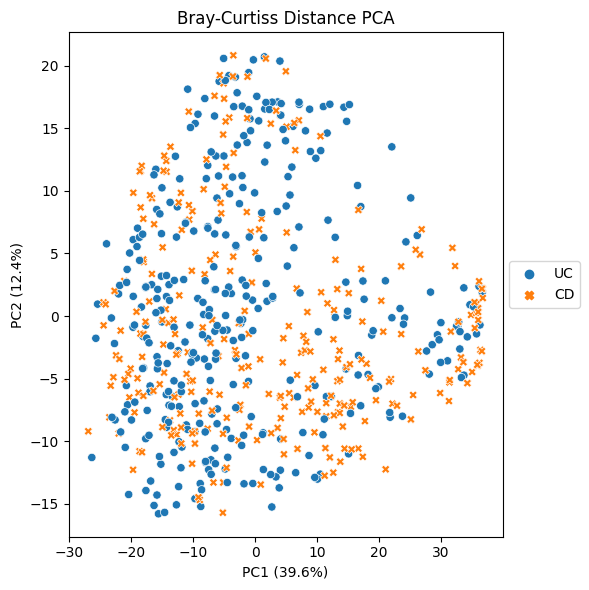

In [18]:
fig, ax = plt.subplots(figsize=(6,6))
sns.scatterplot(data=pct_diag, x='PC1', y='PC2', hue="diagnosis", style='diagnosis', legend=True, ax=ax)
l = ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
l = ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
# If you want, you can plot PC3 vs PC4 by changing x and y above and the labels here
# l = ax.set_xlabel(f"PC3 ({pca.explained_variance_ratio_[2]*100:.1f}%)")
# l = ax.set_ylabel(f"PC4 ({pca.explained_variance_ratio_[3]*100:.1f}%)")
t = ax.set_title(f"Bray-Curtiss Distance PCA")
ax.legend()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()


## Calculate a PCA on the Count Data

In [19]:
scaler = StandardScaler()
scaler.fit(otu.values)
otu_scaled = scaler.transform(otu.values)
otu_scaled

array([[-6.63125831e-01, -4.14212015e-01, -6.37719505e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 8.68755345e-02, -2.46945194e-01,  2.44217633e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 3.22567538e-01, -2.37896973e-02,  2.74837382e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [-5.32759934e-01,  2.49132912e-02, -4.82432186e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.12900780e+00, -3.24390930e-01,  3.87035433e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-2.94974825e-03,  5.94977780e-01,  2.47773831e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [20]:
pca = PCA(n_components=4)
pca.fit(otu_scaled)
otu_pca = pca.transform(otu_scaled)
otu_pca.shape

(631, 4)

In [21]:
zipped = list(zip(otu_pca[:,0],
                  otu_pca[:,1],
                  otu_pca[:,2],
                  otu_pca[:,3],
                  list(otu.index)
                 ))
otu_df = pd.DataFrame(zipped, columns=['PC1', 'PC2', 'PC3', 'PC4', "Sample"])
otu_df.head(3)

,PC1,PC2,PC3,PC4,Sample
0,-3.483781,-2.118369,-0.817237,0.655201,10565
1,-2.314408,-2.240884,0.336644,1.361806,10566
2,-2.002124,-1.672442,-0.715097,0.099708,10567


In [22]:
labels = pd.DataFrame()
labels['diagnosis'] = sample['diagnosis']
otu_diag = otu_df.set_index("Sample").join(labels, how="inner")
otu_diag.head(3)

,PC1,PC2,PC3,PC4,diagnosis
10565,-3.483781,-2.118369,-0.817237,0.655201,UC
10566,-2.314408,-2.240884,0.336644,1.361806,CD
10567,-2.002124,-1.672442,-0.715097,0.099708,UC


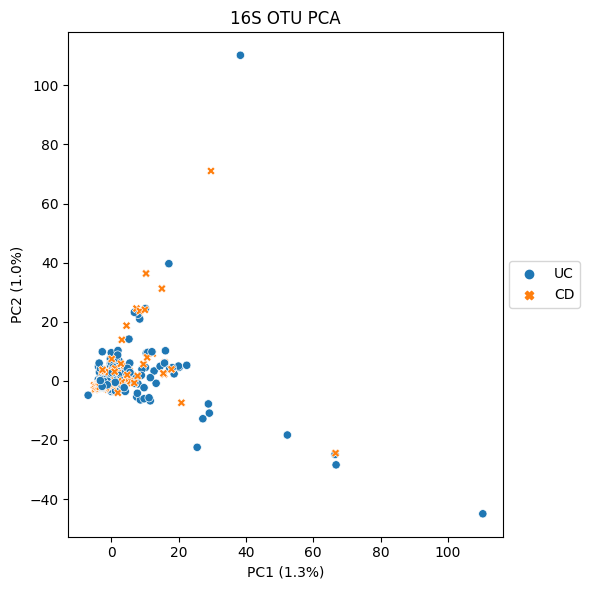

In [23]:
fig, ax = plt.subplots(figsize=(6,6))
sns.scatterplot(data=otu_diag, x='PC1', y='PC2', hue="diagnosis", style='diagnosis', legend=True, ax=ax)
l = ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
l = ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
# If you want, you can plot PC3 vs PC4 by changing x and y above and the labels here
# l = ax.set_xlabel(f"PC3 ({pca.explained_variance_ratio_[2]*100:.1f}%)")
# l = ax.set_ylabel(f"PC4 ({pca.explained_variance_ratio_[3]*100:.1f}%)")
t = ax.set_title(f"16S OTU PCA")
ax.legend()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()

In [24]:
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2', 'PC3', 'PC4'], index=otu.columns)
loadings.head(3)

,PC1,PC2,PC3,PC4
GTAGGTCACAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGCGCAGGCGGGAAGACAAGTTGGAAGTGAAATCTATGGGCTCAACCCATAAACTGCTTTCAAAACTGTTTTTCTTGAGTAGTGCAGAGGTAGGCGGAATTCCCGGTGTAGCGGTGGAATGCGTAGATATCGGGAGGAACACCAGTGGCGAAGGCGGCCTACTGGGCACCAACTGACGCTGAGGCTCGAAAGTGTGGGTAGCAAAC,0.010488,0.015182,0.006244,-0.004264
GGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGATGGATGTTTAAGTCAGTTGTGAAAGTTTGCGGCTCAACCGTAAAATTGCAGTTGATACTGGATATCTTGAGTGCAGTTGAGGCAGGCGGAATTCGTGGTGTAGCGGTGAAATGCTTAGATATCACGAAGAACTCCGATTGCGAAGGCAGCCTGCTAAGCTGCAACTGACATTGAGGCTCGAAAGTGTGGGTATCAAAC,0.001450,0.002333,0.014623,-0.009744
GTAGGTCACAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGCGCAGGCGGGAAGACAAGTTGGAAGTGAAATCCATGGGCTCAACCCATGAACTGCTTTCAAAACTGTTTTTCTTGAGTAGTGCAGAGGTAGGCGGAATTCCCGGTGTAGCGGTGGAATGCGTAGATATCGGGAGGAACACCAGTGGCGAAGGCGGCCTACTGGGCACCAACTGACGCTGAGGCTCGAAAGTGTGGGTAGCAAAC,0.013338,0.014161,0.004547,0.009078


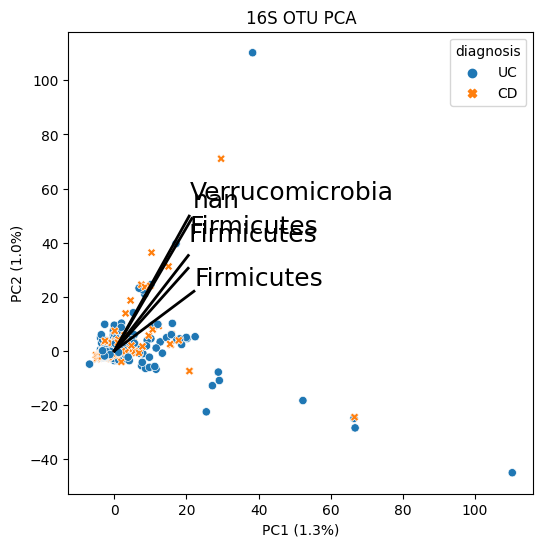

In [25]:
fig, ax = plt.subplots(figsize=(6,6))
sns.scatterplot(data=otu_diag, x='PC1', y='PC2', hue="diagnosis", style='diagnosis', legend=True, ax=ax)
l = ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
l = ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
t = ax.set_title(f"16S OTU PCA")


ldf = loadings.loc[loadings.abs().nlargest(5, ['PC1', 'PC2']).index]
# get the maximum values for x and y for the loadings and the PCA
mlx = max(ldf.PC1)
mly = max(ldf.PC2)
mpx = max(otu_df.PC1)
mpy = max(otu_df.PC2)

c = 0
for i, l in ldf.iterrows():
    c+=2
    # scale the loadings to fit the figure
    ex = ( l.PC1 * (mpx/mlx) ) / 5
    ey = ( l.PC2 * (mpy/mly) ) / 5
    # add the text and the line
    plt.text(ex+0.2, ey+c, tax.loc[i]['Phylum'], fontsize=18)
    plt.plot([0, ex ], [0, ey ], 'k-', lw=2)
